In [1]:
import os
import time
import math
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

# DATA-EDA

## IDEA

### 14조

- mask y값을 측정해서 [0, 0, 1], (0 or 1 or 2)
- mask 색상 반전
- 이미지 데이터를 다루는데는 optimizer가 SGD를 쓰면 좋다. ( 카더라 )
- 도메인이 다른 경우 pretrained를 사용하면 안 좋다. torchvision.models(pretrained=True)

### 13조

- plot을 그려봄. 그거 봄.
- dataframe 쓸 때 for문 쓰시냐?
- data augmentation: 흑백으로 바꿔서 해보자 ( 마스크랑 얼굴은 색이 다르니깐 ), 검은 마스크 같은 경우는 경계선이 확실하지 않다.
- 이미지를 다 로드해놓고 쓰냐, (검은 마스크)

### 23조

- 잡담

In [2]:
import os
from glob import glob

import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
data_dir = '/opt/ml/input/data/train'

In [4]:
os.listdir(data_dir)

['images', '._train.csv', 'train.csv', '._images']

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('/opt/ml/input/data/train/train.csv')

In [7]:
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [10]:
train_df.age.min(), train_df.age.max()

(18, 60)

# HistPlot

- Total
- Male, Female histplot
- Male, Female histplot, kde

In [9]:
import seaborn as sns

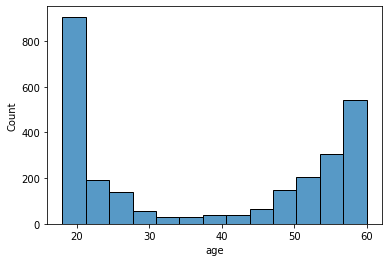

In [10]:
sns.histplot(train_df, x="age")

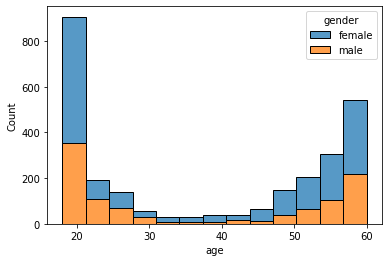

In [11]:
sns.histplot(data=train_df, x="age", hue="gender", multiple="stack")

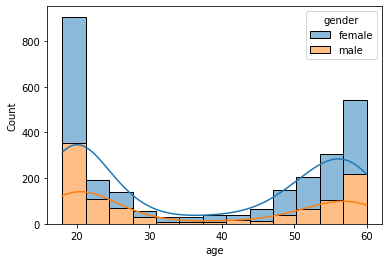

In [12]:
sns.histplot(data=train_df, x="age", hue="gender", multiple="stack", kde=True)

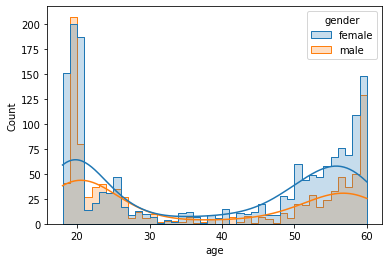

In [13]:
sns.histplot(data=train_df, x="age", hue="gender", element="step", \
             kde=True, binwidth=1)

20대는 남성이 더 많은 데이터

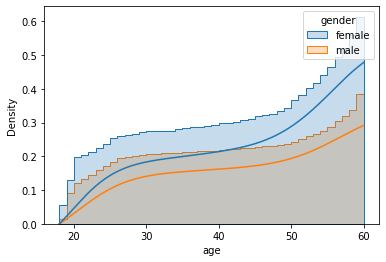

In [14]:
sns.histplot(data=train_df, x="age", hue="gender", element="step", \
             kde=True, binwidth=1, stat="density", cumulative=True)

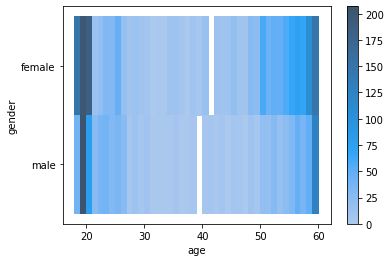

In [15]:
sns.histplot(data=train_df, x="age", y="gender", binwidth=1, cbar=True)

In [16]:
# sns.swarmplot(data=train_df, x="gender", y="age")

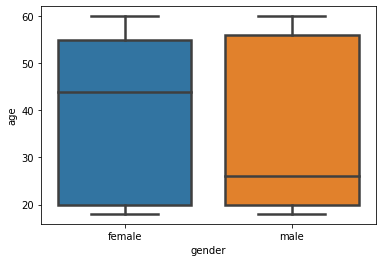

In [17]:
sns.boxplot(data=train_df, x="gender", y="age", linewidth=2.5)

In [18]:
train_df.age.max()

60

나이 최대값이 60이다.. 학습 시킨다면

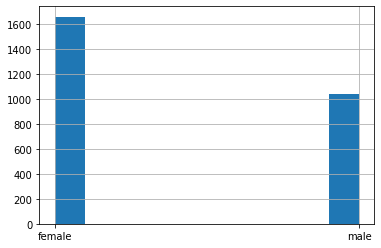

In [19]:
train_df.gender.hist()

In [20]:
train_df.race.unique()

array(['Asian'], dtype=object)

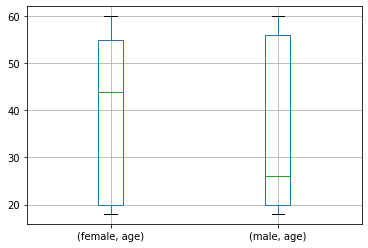

In [21]:
train_df.groupby(["gender"]).boxplot('age')

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df, train_df['age']):
    strat_train_set = train_df.loc[train_index]
    strat_test_set = train_df.loc[test_index]

In [23]:
strat_train_set.head()

,id,gender,race,age,path
154,000531,female,Asian,56,000531_female_Asian_56
2518,006503,female,Asian,28,006503_female_Asian_28
1913,004433,female,Asian,23,004433_female_Asian_23
1776,004222,female,Asian,55,004222_female_Asian_55
2588,006631,female,Asian,19,006631_female_Asian_19


In [24]:
set(strat_train_set['id']).intersection(set(strat_test_set))

set()

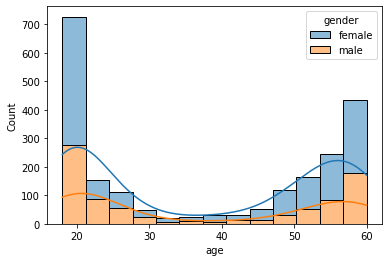

In [25]:
sns.histplot(data=strat_train_set, x="age", hue="gender", multiple="stack", kde=True)

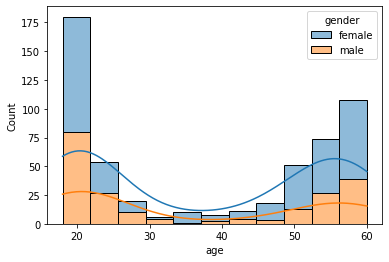

In [26]:
sns.histplot(data=strat_test_set, x="age", hue="gender", multiple="stack", kde=True)

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df, train_df['gender']):
    strat_train_set = train_df.loc[train_index]
    strat_test_set = train_df.loc[test_index]

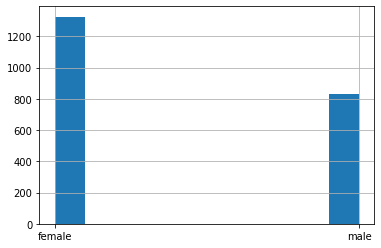

In [28]:
strat_train_set.gender.hist()

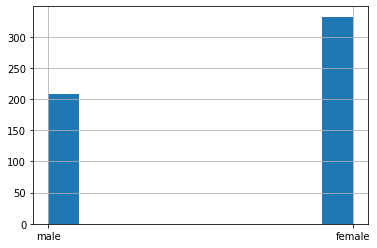

In [29]:
strat_test_set.gender.hist()

In [30]:
len(strat_test_set)

540

In [31]:
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [32]:
len(train_df[train_df["age"] == 60]), len(train_df) # age : [0, 0, 1] # 192
# age category, age numeric, linear regression

# model_predict(age)
# mask, gender, age

(192, 2700)

In [33]:
for path in train_df["path"]:
    print(path)
    break

000001_female_Asian_45


In [34]:
for name in list(train_df['path']):
    if "-1" in name:
        print(name)

000600-1_female_Asian_54
000748-1_female_Asian_54
001024-1_female_Asian_24
001026-1_male_Asian_25
001029-1_female_Asian_23
001038-1_male_Asian_20
001043-1_male_Asian_23
001047-1_male_Asian_20
001131-1_male_Asian_22
001132-1_male_Asian_25
001179-1_female_Asian_24
001182-1_male_Asian_19
001183-1_male_Asian_25
001186-1_male_Asian_24
001187-1_male_Asian_25
001359-1_female_Asian_24
001464-1_female_Asian_56
001492-1_female_Asian_22
001493-1_male_Asian_23
001494-1_female_Asian_23
001495-1_male_Asian_21
001496-1_male_Asian_21
001498-1_male_Asian_23
001517-1_female_Asian_23
001583-1_female_Asian_19
001630-1_female_Asian_34
001645-1_female_Asian_26
001647-1_female_Asian_56
001774-1_female_Asian_52
001775-1_female_Asian_50
001840-1_male_Asian_22
003403-1_female_Asian_50
003424-1_female_Asian_44
003505-1_female_Asian_58
003508-1_female_Asian_60
003509-1_male_Asian_57
003511-1_male_Asian_54
003514-1_male_Asian_20
004319-1_female_Asian_58
005067-1_female_Asian_48


In [35]:
file_path = "/opt/ml/input/data/train/images"

In [36]:
check_images = f"{file_path}/000600-1_female_Asian_54"

In [37]:
os.listdir(check_images)

['._mask5.jpg',
 'mask4.jpg',
 'normal.jpg',
 'mask3.jpg',
 '._mask2.jpg',
 '._mask4.jpg',
 '._mask1.jpg',
 '._incorrect_mask.jpg',
 'mask1.jpg',
 '._normal.jpg',
 'incorrect_mask.jpg',
 'mask5.jpg',
 'mask2.jpg',
 '._mask3.jpg']

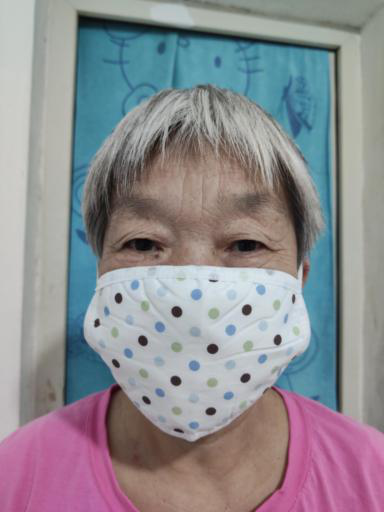

In [38]:
from PIL import Image

Image.open(os.path.join(check_images, "mask5.jpg"))

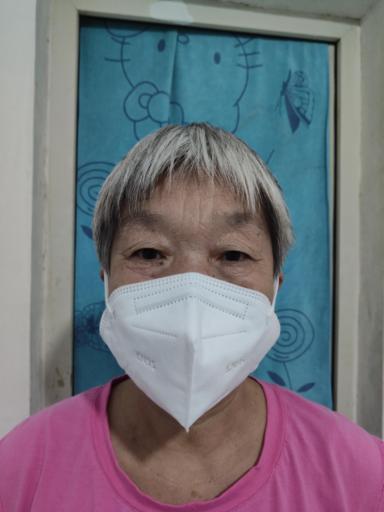

In [39]:
from PIL import Image

Image.open(os.path.join(check_images, "mask1.jpg"))

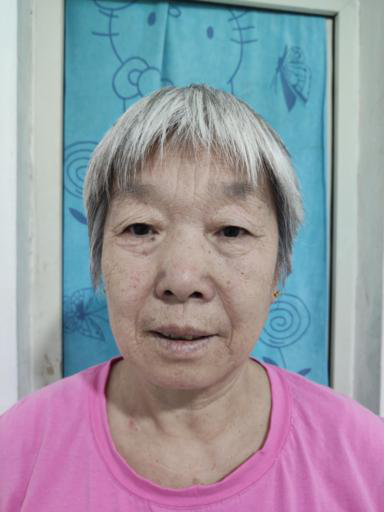

In [40]:
from PIL import Image

Image.open(os.path.join(check_images, "normal.jpg"))

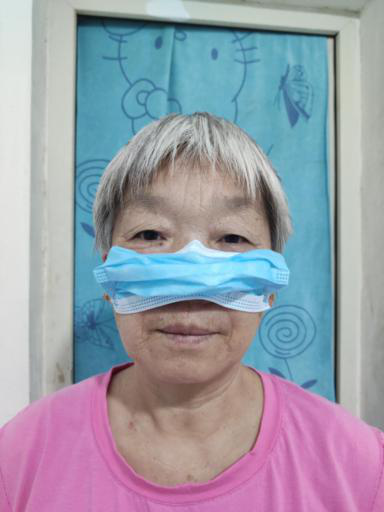

In [41]:
from PIL import Image

Image.open(os.path.join(check_images, "incorrect_mask.jpg"))

In [42]:
check_images = f"{file_path}/005067-1_female_Asian_48"
os.listdir(check_images)

['._mask5.jpg',
 'mask4.jpg',
 'normal.jpg',
 'mask3.jpg',
 '._mask2.jpg',
 '._mask4.jpg',
 '._mask1.jpg',
 '._incorrect_mask.jpg',
 'mask1.jpg',
 '._normal.jpg',
 'incorrect_mask.jpg',
 'mask5.jpg',
 'mask2.jpg',
 '._mask3.jpg']

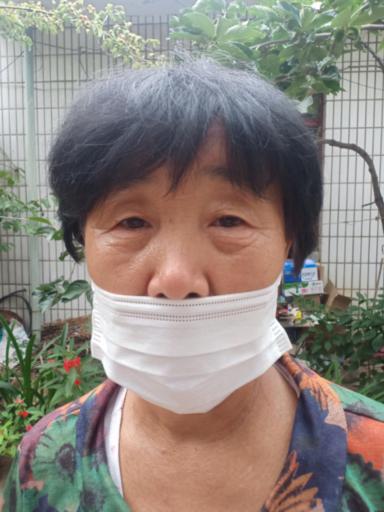

In [43]:
Image.open(os.path.join(check_images, "incorrect_mask.jpg"))

In [44]:
from datetime import datetime

In [45]:
datetime.now().strftime("m:")

'm:'

In [46]:
cc = datetime.now()

In [47]:
cc.strftime('%m%d%H%M')

'03310436'

In [48]:
cc.strptime??

Docstring: string, format -> new datetime parsed from a string (like time.strptime()).
Type:      builtin_function_or_method


In [49]:
check_images

'/opt/ml/input/data/train/images/005067-1_female_Asian_48'

## 데이터 겹치기

In [50]:
file_path

'/opt/ml/input/data/train/images'

In [51]:
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [1]:
image1 = os.path.join(file_path, train_df['path'][0], "mask1.jpg")

NameError: name 'os' is not defined

In [59]:
image2 = os.path.join(file_path, train_df['path'][1], "mask1.jpg")

In [54]:
image1 = Image.open(image1)
image2 = Image.open(image2)

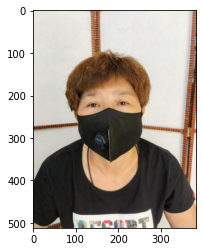

In [55]:
import matplotlib.pyplot as plt
plt.imshow(image1)
plt.imshow(image2)

In [ ]:
import cv2

img1 = cv2.imread(image1)
img2 = cv2.imread(image2)

width = img1.shape[1]
height = img1.shape[0]
img2 = cv2.resize(img2, (width, height))

dst = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
cv2.imshow('dst',dst)

In [ ]:
# cv2.destroyAllWindows()

In [57]:
plt.imshow(dst)

NameError: name 'dst' is not defined